# Assignment 4: Explainability

*Part of the course:
Machine Learning (code: INFOB3ML), Fall 2025, Utrecht University*

Total points: 10 (100%)

Deadline: Friday 31 October, 23:59

The stundets should submit one ipynb file per pair.

**Write your names and student numbers here:**
- Luc Hampsink - 8980713
- Mia Loozekoot - 5022681



Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**



## Installation

For this assignment, we are going to use the following Python packages:

matplotlib, pandas, statsmodels, interpret, scikit-learn, openpyxl and graphviz

In [ ]:
# Installing packages
%pip install graphviz plotnine seaborn
%pip install matplotlib pandas numpy statsmodels scikit-learn openpyxl
%pip install interpret
%pip install scikit-learn --upgrade

## Downloading the data
We are going to use the combined cycle power plant dataset. This dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. We have the following features: hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). We will train ML models to predict the net hourly electrical energy output (EP) of the plant.

For a detailed description, see: [[Description](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant)]

We first need to download and prepare data.


In [ ]:
# Download and unzip data

# Windows users: download the data from https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
# and unzip the file manually in the same folder as the python notebook

# Note: this cell works fine on Linux based systems and Google Colab
# If you run it on a Windows machine, you will get an error (...'wget' is not recognized as an internal or external command...)
!wget -c https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip
!unzip CCPP.zip

## Loading and preprocessing the data
We split the data into training (first 5000 instances) and validation (the subsequent 2000) and test (the last 2568) sets. We will use the training set to train a model, and validation set to optimize the model hyper-parameters.


In [1]:
# Load and prepare data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# global variables
DATA_FILENAME = 'CCPP/Folds5x2_pp.xlsx'
FEATURE_NAMES = ['AT', 'V', 'AP', 'RH']
LABEL_NAME = 'PE'

# Load the data from the excel file
def load_data():
    def split_feature_label(data_set):
        features = data_set[FEATURE_NAMES]
        labels = data_set[LABEL_NAME]
        return features, labels

    data = pd.read_excel(DATA_FILENAME)
    train_set, dev_set, test_set = data[:5000], data[5000: 7000], data[7000:]

    train_features, train_labels = split_feature_label(train_set)
    dev_features, dev_labels = split_feature_label(dev_set)
    test_features, test_labels = split_feature_label(test_set)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels


# preprocess (by z-normalization) the data for the regression task
# return the normalized feature sets and corresponding target variables
def prepare_load_regression_data():
    train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels = load_data()

    scaler = StandardScaler()
    scaler = scaler.fit(train_features)
    train_features = pd.DataFrame(data=scaler.transform(train_features), columns=FEATURE_NAMES)
    dev_features = pd.DataFrame(data=scaler.transform(dev_features), columns=FEATURE_NAMES)
    test_features = pd.DataFrame(data=scaler.transform(test_features), columns=FEATURE_NAMES)

    return train_features, train_labels, dev_features, \
        dev_labels, test_features, test_labels



## Training and Interpreting a Linear Regression Model

**Q1**. (10)% Train a linear regression model (we recommend the statsmodels package) and report $R^2$ (goodness of fit) statistic.

For model interpretability, provide for each feature (+ the bias variable) the following in tabular format:
* Weight estimates
* SE (standard error of estimates)
* T statistics


Further Questions regarding the linear model (answers to be included in the notebook):


**Q2**. (5%) Which three features are the most important?

**A2**: _Importance is signified by the T statistic. A negative weight tends to make PE (the target variable) decrease._
_The three most important features: AT, V, RH_


**Q3**. (10%) How does the gas turbine energy yield (EP) change with unit (one degree C) increase of the ambient temperature given that all other feature values remain the same? (Note: Here you should consider whether you use the original or z-normalized features to train your linear model.)

**A3**: _Ambient temperature, AT, has a weight estimate of $-14.807970$. A one-degree change of AT would change the EP by $1\degree \mathrm{C}\cdot \mathrm{AT}= -14.807970$._

**Q4**. (10%) Show bar graph illustrations of the feature effects for the first two validation set instances.

**A4**: see plot below.

In [4]:
# We recommend the statsmodels package
import statsmodels.api as sm
# Hint, by default this sm does not include the bias/offset term w_0
# thus, you should add it yourself using sm.add_constant()

# Linear regression
# Get the preprocessed data for linear regression modeling
(train_features, train_labels, dev_features,
 dev_labels, test_features, test_labels) = prepare_load_regression_data()

# 'const' column added with only 1s
train_features_w0 = sm.add_constant(train_features)

ols_model = sm.OLS(train_labels, train_features_w0)
ols_result = ols_model.fit()

model_data = pd.DataFrame({
    'Weight estimates': ols_result.params,
    'SE': ols_result.bse,
    'T statistics': ols_result.tvalues,
})

# is rsquared a function or a property?
# My linter says function, my interpreter says attribute/property.
ols_r_squared = ols_result.rsquared

most_important_features = model_data.sort_values("Weight estimates")
print(most_important_features)
print(most_important_features[:3].index.tolist())
print("r_squared: ", r_squared)

       Weight estimates        SE  T statistics
AT           -14.807970  0.155624    -95.152274
V             -2.853379  0.126574    -22.543124
RH            -2.424737  0.083081    -29.185187
AP             0.382037  0.077210      4.948008
const        454.444328  0.063930   7108.416217
['AT', 'V', 'RH']
r_squared:  0.9294006278833447


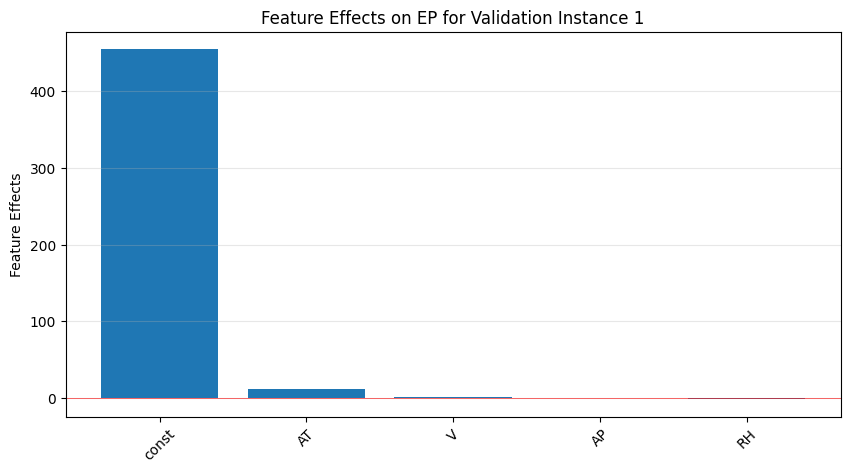

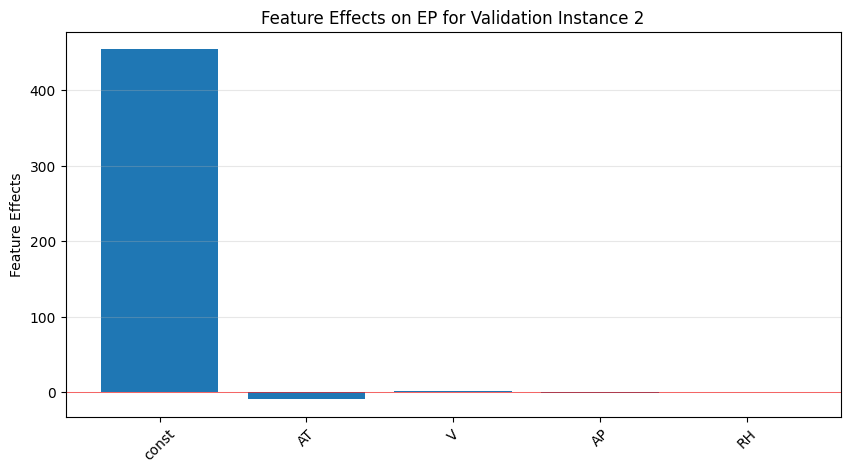

In [3]:
import matplotlib.pyplot as plt

# Assuming the validation sets are the dev_features
validation_features = dev_features
#validation_features = test_features

instances = dev_features[:2]
instances_with_const = sm.add_constant(instances)
predictions = ols_result.predict(instances_with_const)

feature_multiplications = [
    ols_result.params.values * instance
    for instance in instances_with_const.values
]

for i in range(2):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_multiplications[i])), feature_multiplications[i])
    plt.title(f'Feature Effects on EP for Validation Instance {i + 1}')
    plt.xticks(range(len(FEATURE_NAMES) + 1), ['const'] + FEATURE_NAMES, rotation=45)
    plt.ylabel('Feature Effects')

    plt.axhline(0, color='red', linewidth=0.4)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

**Q5**. (5%) Reflection: why would training a regression tree not work well for this dataset in terms of model interpretability? (answer in the notebook)

**A5:** _The feature effect of the $w_0$ parameter is much greater than that of the other parameters and would result in the pruning getting rid of the influence of the other variables._

## Training and Interpreting an Explainable Boosting Model (Generalized Additive Model)
**Q6**. (20% total) Train a Explainable Boosting Machine (with [interpret.ml](https://interpret.ml/docs/ebm.html))

(Note on grading: Training EBM 5%, answering the questions - see below -  5% each)

For a documentation see: [[LIME](https://interpret.ml/docs/lime.html)]

* (5%) Visualize/provide global (model-wise) feature importances for EBM as a table or figure.
* (5%) What are the most important two features in EBM? Are they the same as in the linear model?
  * _AT and V have the greatest importance. And yes: In the linear model, it were AT, V, and RH. The EBM importance matches that of the linear model._
* (5%) Visualize local (instance-wise) feature importances for a development set instance of your choice.

In [5]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import ExplainableBoostingRegressor
# add any other imports you need below

from interpret import show

# EBM
set_visualize_provider(InlineProvider())
ebm = ExplainableBoostingRegressor()
ebm.fit(train_features, train_labels)  # takes 10-30 seconds

,feature_names,None
,feature_types,None
,max_bins,1024
,max_interaction_bins,64
,interactions,'5x'
,exclude,None
,validation_size,0.15
,outer_bags,14
,inner_bags,0
,learning_rate,0.04
,greedy_ratio,10.0


In [ ]:
print("1.")
show(ebm.explain_global("Feature importances"))
print("-"*30+"\n3.")

instance_id = 0
show(ebm.explain_local(dev_features, dev_labels), instance_id)

## Training and Explaining Neural Networks
**Q7**. (15% total) Train a Neural Network (using the training and validation sets): One-layer MLP (ReLU activation function + 50 hidden neurons)

We recommend to use the Adam optimizer. Fine-tune the learning rate and any other hyper-parameters you find necessary.

For a tutorial see: [[Tutorial](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)]

Your code should report the results following the instructions below:

Note on grading: training NN: 5%, answering below sub-questions 5% each.

* (5%) Apply the trained neural network model on the test set and report Root Mean Square Error (RMSE) performance measure.

* (5%) Analyzing factors influencing the neural network predictions.
See the [Documentation](https://scikit-learn.org/stable/modules/partial_dependence.html) to use Partial Dependence Plot (PDP)  implementation in python. Use the trained one-layer MLP model to  Generate and report a bivariate PDP using 'AT' (Ambient Temperature) and 'V' (Exhaust Vacuum) features (Note: not two univariate PDPs but one bivariate PDP).


In [40]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# One-layer MLP : you can use  learning_rate_init=0.001 with relu activation to get a reasonable model,
# optimize other parameters by experimentation
# We advise that you name variable for the mlp regressor model 'mlp_reg' so that it will be consistent
# with the scripts to call your implementation of PFI later in Q8:

mlp_reg = ...  # ... your scripts here and below


mlp_reg = MLPRegressor(
    solver="adam",             # default
    activation="relu",         # default
    hidden_layer_sizes=(50,),
    max_iter=1000,
    learning_rate_init=0.001,  # default
)
mlp_reg.fit(train_features, train_labels)

,loss,'squared_error'
,hidden_layer_sizes,"(50,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,1000
,shuffle,True


RMSE: 4.1516268791590765


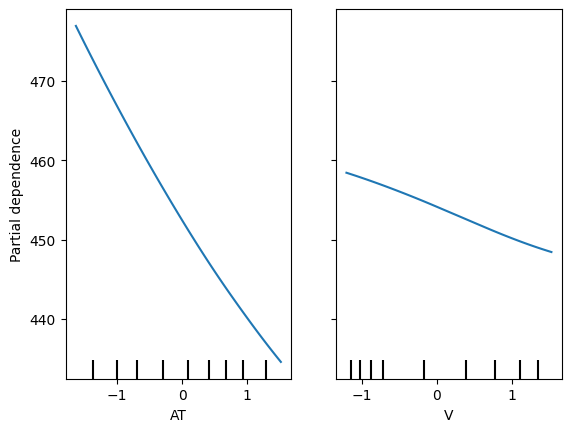

In [44]:
# RSME
mlp_rsquared_test = root_mean_squared_error(dev_labels, mlp_reg.predict(dev_features))
print("RMSE:", mlp_rsquared_test)

# PDP graph
_ = PartialDependenceDisplay.from_estimator(mlp_reg, train_features, features=["AT", "V"])

### Generating Model-Agnostic Global Explanations for NN predictions

**Permutation Feature Importance (PFI)**

**Q8**. (25% total) PFI implementation and testing
- (%15) Implement the permutation feature importance algorithm using RMSE as the error function. No existing libraries (save measuring RMSE) are allowed to use. We will implement it ourselves. Hint: to get a better error estimate per feature perturbation, you can run feature permutation multiple times (e.g., 10 times) and calculate the average.
- (%5) Visualize feature importances obtained by PFI for the NN (one-layer MLP) model you trained using a bar graph.
- (%5) Reflection: What are the most important two features obtained by PFI for MLP model? How do these two features compare to the top two features from the Linear Model and the EBM?

In [ ]:
# Use the below function signature and the parameters to implement PFI
def PFI(X, labels, model, orig_rmse):
# Your scripts implementing PFI here




# Do not modify this part (unless you change the variable name mlp_reg above)
base_rmse = root_mean_squared_error(dev_labels, mlp_reg.predict(dev_features))
results_df = PFI(dev_features, dev_labels, mlp_reg, base_rmse)

In [ ]:
# Your scripts to visualize results_df using a bar graph here